# SYDE 556/750: Simulating Neurobiological Systems

## Learning

- What do we mean by learning?
    - When we use an integrator to keep track of location, is that learning?
    - What about the learning used to complete a pattern in the Raven's Progressive Matrices task?
    - Neither of these require any connection weights to change in the model
    - But both allow future performance to be affected by past performance
    - I suggest the term 'adaptation' to capture all such future-affected-by-past phenomena

- So, we'll stick with a simple definition of learning
    - Changing connection weights between groups of neurons

- Why might we want to change connection weights?
- This is what traditional neural network approaches do
    - Change connection weights until it performs the desired task
    - Once it's doing the task, stop changing the weights
- But we have a method for just solving for the optimal connection weights
    - So why bother learning?

### Why learning might be useful

- We might not know the function at the beginning of the task
    - Example: a creature explores its environment and learns that eating red objects is bad, but eating green objects is good
        - what are the inputs and outputs here?
- The desired function might change
    - Example: an ensemble whose input is a desired hand position, but the output is the muscle tension (or joint angles) needed to get there
        - why would this change?
- The optimal weights we solve for might not be optimal
    - How could they not be optimal?
    - What assumptions are we making?

### The simplest approach

- What's the easiest way to deal with this, given what we know?


- If we need new decoders
    - Let's solve for them while the model's running
    - Gather data to build up our $\Gamma$ and $\Upsilon$ matrices
- Example: eating red but not green objects
    - Decoder from state to $Q$ value (utility of action) for eating
    - State is some high-dimensional vector that includes the colour of what we're looking for
         - And probably some other things, like whether it's small enough to be eaten
    - Initially doesn't use colour to get output
    - But we might experience a few bad outcomes after red, and good after green
    - These become new $x$ samples, with corresponding $f(x)$ outputs
    - Gather a few, recompute decoder
        - Could even do this after every timestep
- Example: converting hand position to muscle commands
    - Send random signals to muscles
    - Observe hand position
    - Use that to train decoders
- Example: going from optimal to even more optimal
    - As the model runs, we gather $x$ values  
    - Recompute decoder for those $x$ values
    

### What's wrong with this approach

- Feels like cheating
- Why?


- Two kinds of problems:
    - Not biologically realistic
        - How are neurons supposed to do all this?
        - store data
        - solve decoders
        - timing
    - Computationally expensive
        - Even if we're not worried about realism

## Traditional neural networks

- Traditionally, learning is the main method of constructing a model network
- How?
- Incremental learning
    - As you get examples, shift the connection weights slightly based on that example
    - Don't have to consider all the data when making an update
- Example: Perceptron learning (1957)
    - $\Delta w_j = \alpha(y_d - y)x_i$

<img src="files/lecture_learning/perceptron.png">

- Problems with perceptron
    - Can't do all possible functions
    - Effectively just linear functions of $x$ (with a threshold; i.e. a linear classifier)
    - Is that a problem (X)OR not?
    


## Backprop and the NEF

- How are nonlinear functions included?
    - Multiple layers
    
<img src="files/lecture_learning/backprop.png" width=600>
    
- But now a new rule is needed
    - Standard answer: backprop
    - Same as perceptron for first layer
    - Backprop adds: Estimate correct "hidden layer" input, and repeat
- What would this be in NEF terms?

- Remember that we're already fine with linear decoding
    - Encoders (and $\alpha$ and $J^{bias}$) are first layer of weights, decoders are second layer
    - Note that in the NEF, we combine many of these layers together
- We can just use the standard perceptron rule for decoders
    - As long as there are lots of neurons, and we've initialized them well with the desired intercepts, maximum rates, and encoders we should be able to decode
    - So, what might backprop add to that?

## Biologically realistic perceptron learning

-  [(MacNeil & Eliasmith, 2011)](http://compneuro.uwaterloo.ca/publications/macneil2011.html)  derive a simple, plausible learning rule starting with a delta rule
- $E = 1/2 \int (x-\hat{x})^2 dx$
- $\delta E/\delta d_i = (x-\hat{x})a_i$ (as usual for finding decoders)
- So, to move down the gradient:
    - $\Delta d_i = -\kappa (x - \hat{x})a_i$ (NEF notation)
    - $\Delta d_i = \kappa (y_d - y)a_i$ (the standard perceptron/delta rule)
- How do we make it realistic?
- Decoders don't exist in the brain
    - Need weights
- The NEF tells us:
    - $\omega_{ij} = \alpha_j d_i \cdot e_j$
    - $\Delta \omega_{ij} = \alpha_j \kappa (y_d - y)a_i \cdot e_j$
- Let's write $(y_d - y)$ as $E$
    - $\Delta \omega_{ij} = \alpha_j \kappa a_i E \cdot e_j$
    - $\Delta \omega_{ij} = \kappa a_i (\alpha_j E \cdot e_j)$
- What's $\alpha_j E \cdot e_j$?
    - That's the current that this neuron would get if it had $E$ as an input
    - But we don't want this current to drive the neuron
    - Rather, we want it to change the weight
    - It's a *modulatory* input
- This is the "Prescribed Error Sensitivity" PES rule
    - Any model in the NEF could use this instead of computing decoders
    - Requires some other neural group computing the error $E$
    - Used in Spaun for Q-value learning (reinforcement task)
    - Can even be used to learn circular convolution
        - Only demonstrated up to 3 dimensions in [(Bekolay et al, 2013)](http://compneuro.uwaterloo.ca/publications/bekolay2013.html)
        - Why not more? Patience.

- Is this realistic?
    - Local information only
    - Need an error signal
        - Does it look like anything like this happens in the brain?
        - Yes
            - Retinal slip error is computed in oculomotor system
            - Dopamine seems to act as prediction error 
    - Weight changes proportional to pre-synaptic activity
    - Most evidence about weight changes is fairly circumstantial

In [59]:
#From the learning examples in nengo - a Communication Channel
%pylab inline
import nengo
from nengo.processes import WhiteNoise

model = nengo.Network('Learn a Communication Channel')
with model:
    stim = nengo.Node(WhiteNoise(60, high=5).f(d=2))
    
    pre = nengo.Ensemble(60, dimensions=2)
    post = nengo.Ensemble(60, dimensions=2)
    
    nengo.Connection(stim, pre)
    conn = nengo.Connection(pre, post, function=lambda x: np.random.random(2))
    
    inp_p = nengo.Probe(stim)
    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

sim = nengo.Simulator(model)
sim.run(10.0)    

Populating the interactive namespace from numpy and matplotlib
Simulation finished in 0:00:04.                                                 


`%matplotlib` prevents importing * from pylab and numpy


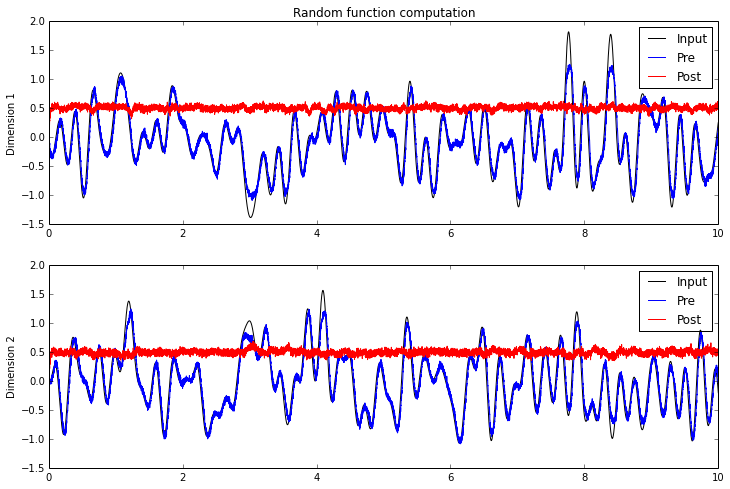

In [60]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(2, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Random function computation')
    
subplot(2, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

In [61]:
#Now learn
with model:
    error = nengo.Ensemble(60, dimensions=2)
    error_p = nengo.Probe(error, synapse=0.03)

    err_fcn = nengo.Connection(pre, error)
    nengo.Connection(post, error, transform=-1)

    error_conn = nengo.Connection(error, post, modulatory=True)

    conn.learning_rule_type = nengo.PES(error_conn)

sim = nengo.Simulator(model)
sim.run(10.0)     

Simulation finished in 0:00:06.                                                 


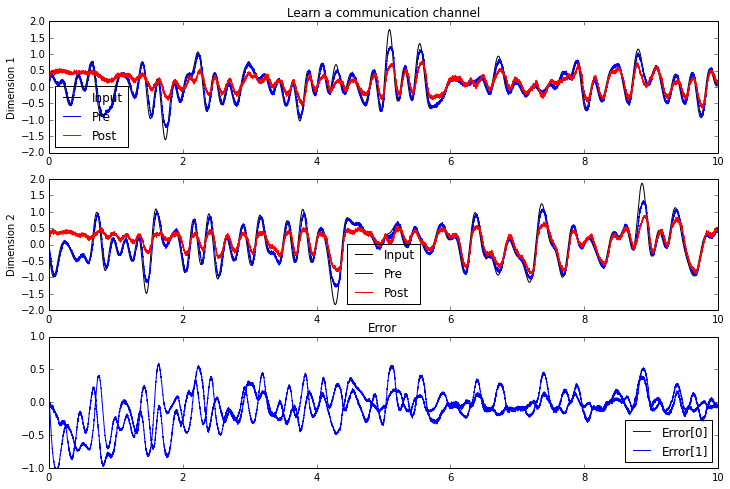

In [62]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(3, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Learn a communication channel')
    
subplot(3, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

subplot(3, 1, 3)
plot(sim.trange(), sim.data[error_p], c='b')
ylim(-1, 1)
legend(("Error[0]", "Error[1]"), loc='best');
title('Error')

In [63]:
#Turning learning on and off to test generalization
def inhibit(t):
    return 2.0 if t > 10.0 else 0.0

with model:
    inhib = nengo.Node(inhibit)
    inhib_conn = nengo.Connection(inhib, error.neurons, transform=[[-1]] * error.n_neurons)
    
sim = nengo.Simulator(model)
sim.run(16.0)

Simulation finished in 0:00:09.                                                 


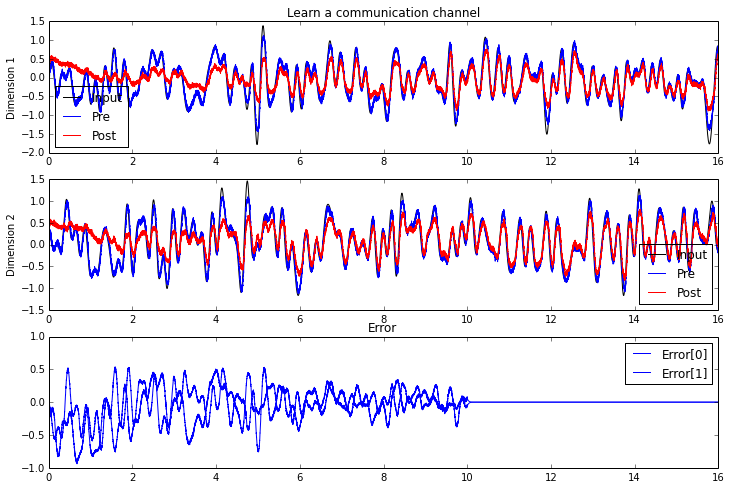

In [64]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(3, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Learn a communication channel')
    
subplot(3, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

subplot(3, 1, 3)
plot(sim.trange(), sim.data[error_p], c='b')
ylim(-1, 1)
legend(("Error[0]", "Error[1]"), loc='best');
title('Error')

In [67]:
#Compute a nonlinear functions
model.connections.remove(err_fcn)
del err_fcn
model.connections.remove(inhib_conn)
del inhib_conn

def nonlinear(x):
    return x[0]*x[0], x[1]*x[1]

with model:
    err_fcn = nengo.Connection(pre, error, function=nonlinear)
    
    conn.learning_rule_type.learning_rate=3e-6        
    
sim = nengo.Simulator(model)
sim.run(26.0)

Simulation finished in 0:00:14.                                                 


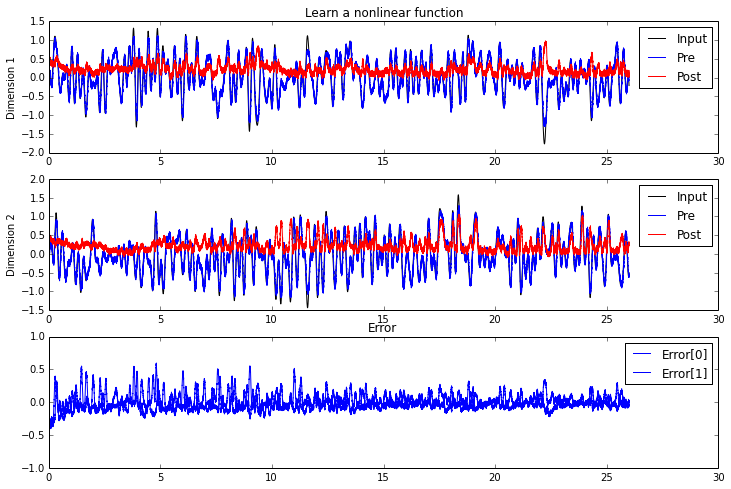

In [69]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(3, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Learn a nonlinear function')
    
subplot(3, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

subplot(3, 1, 3)
plot(sim.trange(), sim.data[error_p], c='b')
ylim(-1, 1)
legend(("Error[0]", "Error[1]"), loc='best');
title('Error')

- This rule can be used to learn any nonlinear vector function
- It does as well, or better, than the NEF decoder optimization
- It's a 'spike-based' rule... meaning it works in a spiking network
- It has been used for 'constant supervision' as well as 'reinforcement learning' (occasional supervision) tasks (Spaun uses it for the RL task)
- It moves the focus of learning research from weight changes or 'learning rules' to error signals
- Backprop is one way of propagating error signals (unfortunately not bio-plausible)
- Pretty much ignores encoders (which should maybe be about capturing all the incoming information, so as to compute any function over that information)

### Unsupervised learning

- Hebbian learning
    - Neurons that fire together, wire together
    - $\Delta \omega_{ij} = \kappa a_i a_j$
    - Just that would be unstable
         - Why?

- BCM rule (Bienenstock, Cooper, & Munro, 1982)
    - $\Delta \omega_{ij} = \kappa a_i a_j (a_j-\theta)$
    - $\theta$ is an activity threshold
        - If post-synaptic neuron is more active than this threshold, increase strength
        - Otherwise decrease it
    - Other than that, it's a standard Hebbian rule
    - Where would we get $\theta$?
        - Need to store something about the overall recent activity of neuron $j$ so it can be compared to its current activity
        - Just have $\theta$ be a pstc-filtered spiking of $a_j$   

In [53]:
import nengo

model = nengo.Network()
with model:
    sin = nengo.Node(lambda t: np.sin(t*4))
    
    pre = nengo.Ensemble(100, dimensions=1)
    post = nengo.Ensemble(100, dimensions=1)

    nengo.Connection(sin, pre)
    conn = nengo.Connection(pre, post, solver=nengo.solvers.LstsqL2(weights=True))

    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

sim = nengo.Simulator(model)
sim.run(2.0)

Simulation finished in 0:00:01.                                                 


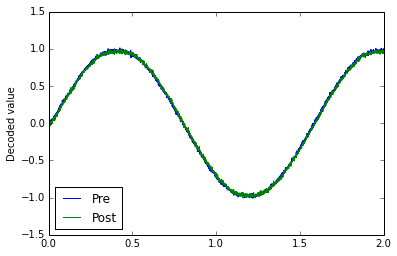

In [54]:
plot(sim.trange(), sim.data[pre_p], label="Pre")
plot(sim.trange(), sim.data[post_p], label="Post")
ylabel("Decoded value")
legend(loc="best");

In [55]:
conn.learning_rule_type = nengo.BCM(learning_rate=5e-10)

with model:
    trans_p = nengo.Probe(conn, 'transform', synapse=0.01, sample_every=0.01)

sim = nengo.Simulator(model)
sim.run(20.0)

Simulation finished in 0:00:09.                                                 
0.169414519413


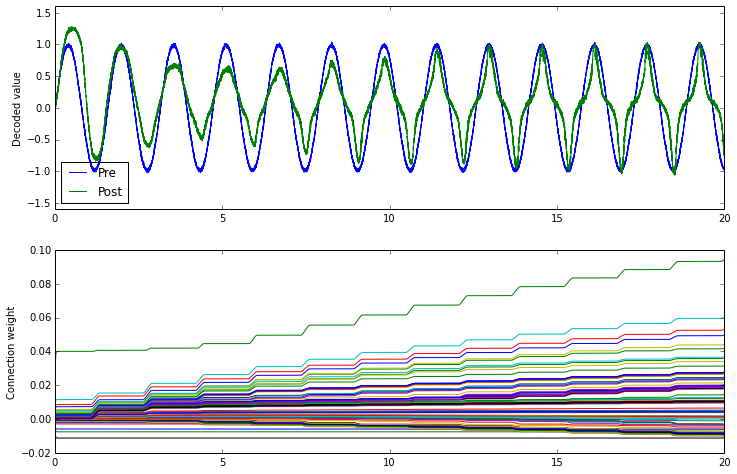

In [58]:
figure(figsize=(12, 8))
subplot(2, 1, 1)
plot(sim.trange(), sim.data[pre_p], label="Pre")
plot(sim.trange(), sim.data[post_p], label="Post")
ylabel("Decoded value")
ylim(-1.6, 1.6)
legend(loc="lower left")

subplot(2, 1, 2)
# Find weight row with max variance
neuron = np.argmax(np.mean(np.var(sim.data[trans_p], axis=0), axis=1))
plot(sim.trange(dt=0.01), sim.data[trans_p][..., neuron])
ylabel("Connection weight");

In [56]:
def sparsity_measure(vector):
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation

print "Starting sparsity: {0}".format(sparsity_measure(sim.data[trans_p][0]))
print "Ending sparsity: {0}".format(sparsity_measure(sim.data[trans_p][-1]))

Starting sparsity: 0.169414519413
Ending sparsity: 0.476120157665


- Result: only a few neurons will fire
    - Sparsification
- What would this do in NEF terms?        
    - Still represent $x$, but with very sparse encoders (assuming the fucn doesn't change)
- This is still a rule on the weight matrix, but functionally seems to be more about encoders than decoders
    - What could we do, given that?  

## The homeostatic Prescribed Error Sensitivity (hPES) rule

- Just do them both [(Bekolay et al., 2013)](http://compneuro.uwaterloo.ca/publications/bekolay2013.html)
- And have a parameter $S$ to adjust how much of each
- $\Delta \omega_{ij} = \kappa \alpha_j a_j (S e_j \cdot E + (1-S) a_j (a_j-\theta))$

- Works as well (or better) than PES
    - Seems to be a bit more stable, but analysis is ongoing
- Biological evidence?
    - Spike-Timing Dependent Plasticity

<img src="files/lecture_learning/STDP.png" width=500>

<img src="files/lecture_learning/STDP2.png" width=500>

- Still work to do for comparison, but seems promising
- Error-driven for improving decoders
- Hebbian sparsification to improve encoders
    - Perhaps to sparsify connections (energy savings in the brain, but not necessarily in simulation)
    
